# GNSS Radio Occultation Observations

Global Navigation Satellite System (GNSS) Radio Occultation (RO) samples the environment by observing changes to GNSS signals as the pass through the Earth's atmosphere. This TAT-C analysis function models when and where GNSS-RO observations can be sampled at the tangent point between a receiver and transmitter, i.e., point along the line-of-sight with minimum distance to the geocenter. This analysis *does not* consider atmospheric refraction, therefore represents only a coarse estimate of GNSS-RO observations suitable for early-stage mission analysis.

## Mathematical Basis

### Transmitter/Receiver Geometry

Assume the transmitter (tx) and receiver (rx) have positions $x_{tx}$ and $x_{rx}$ and velocities $v_{tx}$ and $v_{rx}$, respectively, in a geocentric inertial frame. The transmitter has position $x_{rx,tx}=x_{tx}-x_{rx}$ and velocity $v_{rx,tx}=v_{tx}-v_{rx}$ relative to the receiver.

<img src="../_static/CollectRO/ro1.png" width=300>

The tangent point has position (via vector geometry):

$x_{tp} = x_{tx} - \left(x_{tx} \cdot \frac{x_{rx,tx}}{||x_{rx,tx}||}\right) x_{rx,tx}$ 

and velocity (via the chain rule):

$v_{tp} = \frac{d x_{tp}}{dt}  = v_{tx} - \left(x_{tx} \cdot \frac{x_{rx,tx}}{||x_{rx,tx}||}\right) v_{rx,tx} - \left[ \frac{v_{tx} \cdot x_{rx,tx} + x_{tx} + v_{rx,tx}}{||x_{rx,tx}||} - 2\frac{\left(x_{tx}\cdot x_{rx,tx}\right)\left(v_{rx,tx}\cdot x_{rx,tx}\right)}{||x_{rx,tx}||^2} \right] x_{rx,tx}$

The pitch angle of the transmitter as viewed by the receiver (above/below local horizon) is given by

$\theta_{rx,tx} = \text{atan2} \left( \tilde{x}_{tx,rx}^n \cdot \frac{x_{rx}}{||x_{rx}||}, \tilde{x}_{tx,rx}^n \cdot \frac{v_{rx}}{||v_{rx}||} \right)$

where

$\tilde{x}_{tx,rx}^n = x_{tx,rx} - (n_{rx} \cdot x_{tx,rx}) n_{rx}$ 

is the relative transmitter position in the plane normal to the receiver orbit, and 

$n_{rx} = \frac{ x_{rx} \times v_{rx}}{||x_{rx} \times v_{rx}||}$ 

is the unit normal to the receiver orbit plane.

<img src="../_static/CollectRO/ro3.png" width=300>

The yaw angle of the transmitter as viewed by the receiver (left/right along local horizontal) is given by

$\Omega_{rx,tx} = \text{atan2} \left( \tilde{x}_{tx,rx}^t \cdot n_{rx}, \tilde{x}_{tx,rx}^t \cdot \frac{v_{rx}}{||v_{rx}||} \right)$

where

$\tilde{x}_{tx,rx}^t = x_{tx,rx} - (\frac{ x_{rx} }{||x_{rx} ||} \cdot x_{tx,rx}) \frac{ x_{rx} }{||x_{rx} ||}$ 

is the relative transmitter position in the plane tangent to the receiver orbit.

<img src="../_static/CollectRO/ro4.png" width=300>

### RO Observation Criteria

There are three criteria for a valid RO observation.

First, the tangent point must be between the transmitter and receiver:

$\text{sgn} \left( (x_{tp} - x_{tx}) \cdot (x_{tp} - x_{rx}) \right) < 0$

<img src="../_static/CollectRO/ro2.png" width=300>

Second, the absolute value yaw angle of the transmitter as viewed by the receiver must be within a maximum bound due to antenna gain patterns:

$\text{mod}\left( | \Omega_{rx,tx}|, 180 - \Omega_{max} \right) < \Omega_{max}$

Third, the height of the tangent point must be within a specified range:

$h_{min} < h < h_{max}$

where $h$ is elevation of the tangent point $x_{tp}$ above a specified geoid such as WGS 84.

## Analysis

First, we define scenario configurations. Three parameters set valid GNSS-RO observation conditions between a receiver and transmitter:
 * `max_yaw` sets the maximum yaw angle (in degrees) between the receiver and transmitter within the receiver's orbit plane.
 * `range_elevation` sets the minimum and maximum allowable elevation (in meters) of the tangent point between receiver and transmitter. While realistic GNSS-RO observations sample the atmosphere, a negative minimum value accounts for the lack of refraction considered in this analysis.
 * `sample_elevation` sets the elevation (in meters) of the tangent point to represent a GNSS-RO observation as a single point, rather than an arc through space.

Other scenario parameters configure the temporal bounds of analysis (`start` and `duration`) and set the temporal resolution of orbital motion (`time_step`).

In [1]:
from datetime import datetime, timedelta, timezone
import numpy as np

# occultation validity constraints
max_yaw = 65  # deg
range_elevation = (-200e3, 60e3)  # m
sample_elevation = 0  # m

# scenario configuration
start = datetime(2023, 12, 9, tzinfo=timezone.utc)
time_step = timedelta(seconds=10)
duration = timedelta(hours=1)
times = np.array([start + i * time_step for i in range(duration // time_step)])

Each analysis relies on the definition of a GNSS receiver (e.g., COSMIC-2 FMS) and one or more GNSS transmitters (e.g., the GPS, GLONASS, Galileo, and BeiDou constellations). The code below imports two line elements (TLEs) for each satellite orbit (as of late 2023) and builds a TAT-C `Satellite` object.

In [2]:
from tatc.schemas import Satellite, TwoLineElements

txs = []

for gnss_dat in ["gps_tle.dat", "glo_tle.dat", "gal_tle.dat", "bei_tle.dat"]:
    with open(gnss_dat, "r") as f:
        lines = f.read().splitlines()
        for i in range(0, len(lines), 3):
            txs.append(
                Satellite(
                    name=lines[i], orbit=TwoLineElements(tle=lines[i + 1 : i + 3])
                )
            )

rx = Satellite(
    name="COSMIC-2 FM5",
    orbit=TwoLineElements(
        tle=[
            "1 44358U 19036V   23354.40324524  .00015027  00000-0  91237-3 0  9994",
            "2 44358  24.0023   0.0734 0003537 251.0816 108.9304 15.08623759245240",
        ]
    ),
)

TAT-C simulates GNSS-RO observations using the `collect_ro_observations` script. The function propagates the position of the receiver and transmitters and computes the three conditions required for a valid GNSS-RO observation: 1) the tangent point must between the receiver and transmitter, 2) the acute receiver-transmitter azimuth angle must be less than `max_azimuth`, and 3) the tangent point elevation must be within the `range_elevation` range.

The outputs report each RO observation including the following fields:
 * `receiver`: the receiver satellite name
 * `transmitter`: the transmitter satellite name
 * `is_rising`: true, if the receiver-transmitter azimuth angle is less than `max_azimuth` (false indicates it is greater than 180 - `max_azimuth`)
 * `geometry`: a multipoint geometry that describes the observation arc of points separated by `time_step`
 * `position`: a point geometry that describes the observation closest to the `sample_elevation` value
 * `rx_tx_azimuth`: the transmitter azimuth angle as viewed by the receiver
 * `tp_tx_azimuth`: the transmitter azimuth angle as viewed by the tangent point (i.e., degrees clockwise from North)
 * `start`: start of the RO observation arc
 * `end`: end of the RO observation arc
 * `time`: time of the observation closest to the `sample_elevation` value


In [3]:
from tatc.analysis import collect_ro_observations

ro_obs = collect_ro_observations(
    rx, txs, times, sample_elevation, max_yaw, range_elevation
)
display(ro_obs)

receiver           transmitter  is_rising  \
0    COSMIC-2 FM5     COSMOS 2544 (759)      False   
1    COSMIC-2 FM5     BEIDOU-2 G7 (C03)      False   
2    COSMIC-2 FM5    GSAT0204 (PRN E22)       True   
3    COSMIC-2 FM5     BEIDOU-3 G3 (C61)      False   
4    COSMIC-2 FM5    GSAT0203 (PRN E26)      False   
..            ...                   ...        ...   
146  COSMIC-2 FM5     BEIDOU-3 M4 (C22)       True   
147  COSMIC-2 FM5    GSAT0207 (PRN E07)       True   
148  COSMIC-2 FM5   BEIDOU-3S M1S (C58)       True   
149  COSMIC-2 FM5    GSAT0216 (PRN E25)      False   
150  COSMIC-2 FM5  GPS BIIF-8  (PRN 03)      False   

                                              geometry  \
0    MULTIPOINT Z (-152.24639 5.87018 -11646.86492,...   
1    MULTIPOINT Z (-168.77797 -15.03795 -140025.898...   
2       MULTIPOINT Z (-123.08294 -4.46644 57923.54396)   
3    MULTIPOINT Z (-168.50136 -15.59247 -124560.113...   
4    MULTIPOINT Z (-165.25272 -18.51316 24431.44635...   
..                                                 ...   
146  MULTIPOINT Z (95.25671 28.47814 -190160.40703,...   
147  MULTIPOINT Z (89.26169 40.17079 -198293.02664,...   
148  MULTIPOINT Z (80.94614 1.42298 -192855.92275, ...   
149       MULTIPOINT Z (47.39231 31.78258 40877.89147)   
150       MULTIPOINT Z (47.04757 22.79154 48479.86798)   

                                              position  rx_tx_pitch  \
0    POINT Z (-152.24639134207632 5.870177684212605...  -149.074389   
1    POINT Z (-168.777966271212 -15.037947997571496...  -152.538718   
2    POINT Z (-123.08293904327134 -4.46644352437847...   -29.775128   
3    POINT Z (-168.5013603402097 -15.59246934311023...  -152.632620   
4    POINT Z (-165.16079898966274 -18.8442255263013...  -153.873103   
..                                                 ...          ...   
146  POINT Z (95.98086660490858 27.48180072751837 -...   -23.530439   
147  POINT Z (92.55965764852719 37.22600268170678 -...   -28.231748   
148  POINT Z (84.29195884313161 2.835094888500308 -...   -41.111506   
149  POINT Z (47.39230765619903 31.78257736639128 4...  -155.569813   
150  POINT Z (47.04757402738628 22.79154028163051 4...  -158.296700   

      rx_tx_yaw  tp_tx_azimuth                     start  \
0    135.296849     334.500786 2023-12-09 00:00:00+00:00   
1   -157.610317     273.570918 2023-12-09 00:00:00+00:00   
2     46.320778      59.395134 2023-12-09 00:00:00+00:00   
3   -156.364285     272.373899 2023-12-09 00:00:00+00:00   
4   -148.877346     264.656146 2023-12-09 00:00:00+00:00   
..          ...            ...                       ...   
146   11.903206      87.200330 2023-12-09 00:58:40+00:00   
147   38.031443      61.257391 2023-12-09 00:58:10+00:00   
148  -57.894098     149.109229 2023-12-09 00:58:40+00:00   
149  152.235333     284.790384 2023-12-09 00:59:50+00:00   
150  176.535936     262.020597 2023-12-09 00:59:50+00:00   

                          end                      time  
0   2023-12-09 00:01:50+00:00 2023-12-09 00:00:00+00:00  
1   2023-12-09 00:00:20+00:00 2023-12-09 00:00:00+00:00  
2   2023-12-09 00:00:00+00:00 2023-12-09 00:00:00+00:00  
3   2023-12-09 00:00:20+00:00 2023-12-09 00:00:00+00:00  
4   2023-12-09 00:01:40+00:00 2023-12-09 00:00:10+00:00  
..                        ...                       ...  
146 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  
147 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  
148 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  
149 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  
150 2023-12-09 00:59:50+00:00 2023-12-09 00:59:50+00:00  

[151 rows x 11 columns]

The RO observations can be better visualized by combining with the receiver orbit track.

In [4]:
from tatc.analysis import collect_orbit_track
from tatc.schemas import Instrument

orbit_track = collect_orbit_track(rx, Instrument(name="Default"), times)

The resulting plot shows the receiver orbit track and RO observations categorized as rising or setting.

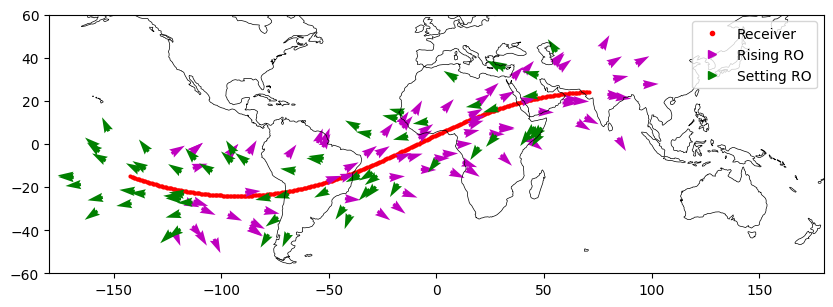

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

world_map = gpd.read_file("ne_110m_land.zip")

fig, ax = plt.subplots(figsize=(10, 4))
orbit_track.plot(ax=ax, marker=".", color="r", lw=0)
world_map.dissolve().boundary.plot(ax=ax, color="black", lw=0.5)
ax.quiver(
    ro_obs.apply(lambda r: r.position.x, axis=1),
    ro_obs.apply(lambda r: r.position.y, axis=1),
    ro_obs.apply(lambda r: np.sin(np.radians(r.tp_tx_azimuth)), axis=1),
    ro_obs.apply(lambda r: np.cos(np.radians(r.tp_tx_azimuth)), axis=1),
    color=ro_obs.apply(lambda r: "m" if r.is_rising else "g", axis=1),
    scale=50,
    scale_units="width",
)
ax.set_xlim([-180, 180])
ax.set_ylim([-60, 60])
ax.legend(
    handles=[
        Line2D([0], [0], marker=".", color="r", lw=0, label="Receiver"),
        Line2D([0], [0], marker=">", color="m", lw=0, label="Rising RO"),
        Line2D([0], [0], marker=">", color="g", lw=0, label="Setting RO"),
    ]
)
plt.show()

An animation can show the dynamic collection of RO observations aggregated to individual frames.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import geopandas as gpd
from IPython.display import HTML
from datetime import timedelta

world_map = gpd.read_file("ne_110m_land.zip")

fig, ax = plt.subplots(figsize=(10, 4))

frame_duration = timedelta(minutes=1)
num_frames = int(duration / frame_duration)


def animate(frame):
    ax.clear()
    time = times[0] + frame * frame_duration
    orbit_track.loc[
        (orbit_track.time >= time) & (orbit_track.time < time + frame_duration)
    ].plot(ax=ax, marker=".", color="r", lw=0)
    world_map.dissolve().boundary.plot(ax=ax, color="black", lw=0.5)
    ro_obs_filtered = ro_obs.loc[
        (ro_obs.start >= time) & (ro_obs.start < time + frame_duration)
    ]
    if not ro_obs_filtered.empty:
        ro_obs_filtered.apply(
            lambda r: ax.plot(
                [point.x for point in r.geometry.geoms],
                [point.y for point in r.geometry.geoms],
                ".m" if r.is_rising else ".g",
                markersize=1,
            ),
            axis=1,
        )
        ax.quiver(
            ro_obs_filtered.apply(lambda r: r.position.x, axis=1),
            ro_obs_filtered.apply(lambda r: r.position.y, axis=1),
            ro_obs_filtered.apply(
                lambda r: np.sin(np.radians(r.tp_tx_azimuth)), axis=1
            ),
            ro_obs_filtered.apply(
                lambda r: np.cos(np.radians(r.tp_tx_azimuth)), axis=1
            ),
            color=ro_obs_filtered.apply(lambda r: "m" if r.is_rising else "g", axis=1),
            scale=50,
            scale_units="width",
        )
    ax.set_title(
        time.strftime("%x %X") + "$-$" + (time + frame_duration).strftime("%X")
    )
    ax.set_xlim([-180, 180])
    ax.set_ylim([-60, 60])
    ax.legend(
        handles=[
            Line2D([0], [0], marker=".", color="r", lw=0, label="Receiver"),
            Line2D([0], [0], marker=">", color="m", lw=0, label="Rising RO"),
            Line2D([0], [0], marker=">", color="g", lw=0, label="Setting RO"),
        ]
    )
    fig.tight_layout()


ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=200, blit=False)
display(HTML(ani.to_jshtml()))
plt.close()